# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order


plt.rcParams['figure.figsize'] = (14,6)

# Read Data & Inspect

In [2]:
df = pd.read_csv("data/TG_STAID002759.txt", skiprows=19, index_col=1, parse_dates=True)

In [3]:
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [4]:
df.isna().sum()

 SOUID    0
   TG     0
 Q_TG     0
dtype: int64

# Clean Data

### Rename columns

In [5]:
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

In [6]:
df.columns = ['SOUID', 'TG', 'Q_TG']

### Missing Values

In [7]:
print(df[df['Q_TG'] == 9])

             SOUID    TG  Q_TG
    DATE                      
1945-04-25  127488 -9999     9
1945-04-26  127488 -9999     9
1945-04-27  127488 -9999     9
1945-04-28  127488 -9999     9
1945-04-29  127488 -9999     9
...            ...   ...   ...
1945-11-01  127488 -9999     9
1945-11-02  127488 -9999     9
1945-11-03  127488 -9999     9
1945-11-04  127488 -9999     9
1945-11-05  127488 -9999     9

[195 rows x 3 columns]


#### Replace missing values with average of daily temperatures of previous and following year

In [8]:
def clean_data(df):
    # Get missing values
    missing_values = df[df['Q_TG'] == 9]
    # Get values for the missing data 1 year before and after
    missing_values_1y_bf = missing_values.index - pd.DateOffset(years=1)
    missing_values_1y_af = missing_values.index + pd.DateOffset(years=1)

    temp_replace = (df[missing_values_1y_bf.min():missing_values_1y_bf.max()].reset_index()['TG'] \
+ df[missing_values_1y_af.min():missing_values_1y_af.max()].reset_index()['TG'])/2
    temp_replace.index = missing_values.index
    df.loc[(df['Q_TG'] == 9), 'TG'] = temp_replace

#### Remove unnessary columns and create time features

In [9]:
def time_features(df):
    df['temp'] = df['TG'] / 10
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df = df.drop(['SOUID','Q_TG', 'TG'], axis=1)
    
    return df

In [10]:
def feature_eng(df, test=False):
    """
    Extracts general trend, seasonality, daily dependence and lags of remainder of an temperature dataframe
    
    Parameter
    ---------
    df = time-series dataframe
    test = Boolean to check if test or train data

    Returns
    -------

    X - feature engineered X-Matrix as Pandas DataFrame
    """

    # Empty DataFrame
    feature_df = pd.DataFrame(index=df.index)
    ## General trend
    if test == False:
        feature_df['timestep'] = list(range(len(df.index)))
    else:
        None
    # Seasonality
    season_dummies = pd.get_dummies(train.index.month, prefix='month', drop_first=True).set_index(df.index)
    feature_df = feature_df.join(season_dummies)
    # Day of the month
    #day_dummies = pd.get_dummies(train['day'], prefix='day', drop_first=True).set_index(df.index)
    #feature_df = feature_df.join(day_dummies)
    # Remainder
    X = feature_df
    y = df['temp'] 
    feature_df['remainder'] = create_remainder(X, y)
    # Create Lags of Remainder
    feature_df['lag1'] = feature_df['remainder'].shift(1)
    feature_df['lag2'] = feature_df['remainder'].shift(2)
    feature_df.dropna(inplace=True)
    feature_df.drop('remainder', axis=1, inplace=True)
    return feature_df

In [12]:
def create_remainder(X, y):
    m = LinearRegression()
    m.fit(X,y)
    prediction = pd.Series(m.predict(X), index=y.index)
    remainder = y - prediction

    return remainder

In [11]:
clean_data(df)

## Train-Test-Split

In [13]:
train = df.iloc[:-365]

In [193]:
test = df.iloc[-365:]

## Add time features and drop columns

In [15]:
train = time_features(train)

# EDA

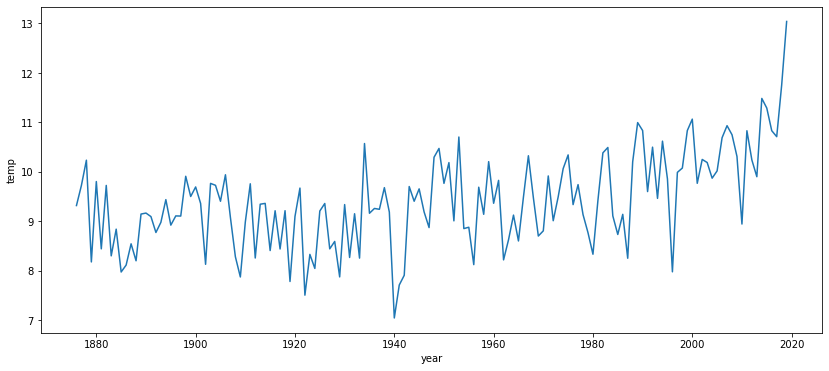

In [16]:
sns.lineplot(x='year', y='temp', data=train.resample('Y').mean())

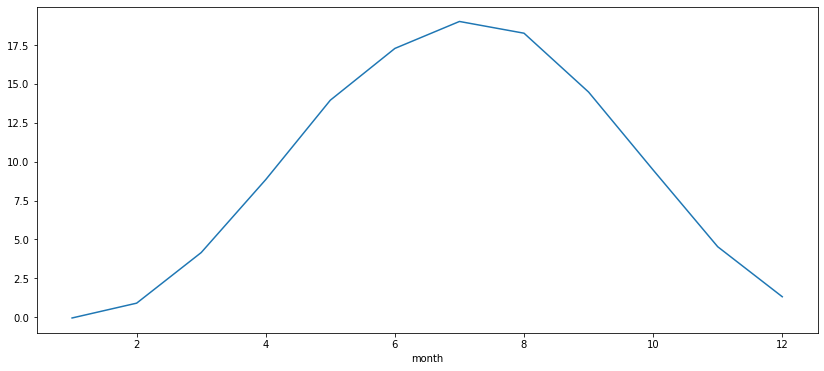

In [17]:
train.groupby(['month']).mean()['temp'].plot()

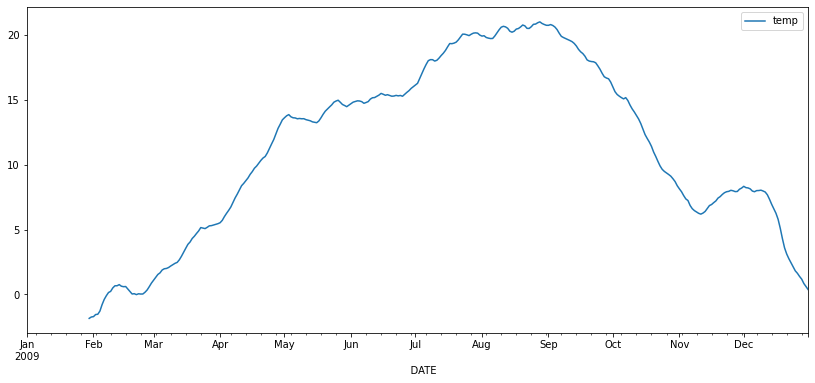

In [18]:
train.loc['2009', ['temp']].rolling(30).mean().plot()

# Model data

## Baseline Model

In [19]:
train.columns

Index(['temp', 'year', 'month', 'day'], dtype='object')

In [20]:
baseline = LinearRegression()
#X =  train[['year', 'month']]
X = train[['year', 'month', 'day']]
y = train['temp']

baseline.fit(X,y)
baseline.score(X,y)

0.04056701237324911

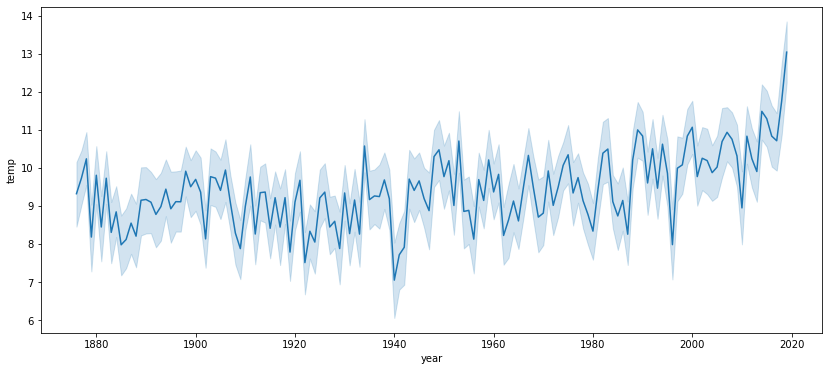

In [21]:
sns.lineplot(x=train['year'], y=train['temp'])

## Feature Engineering

## General trend

In [22]:
train['timestep'] = list(range(len(train.index)))

In [23]:
X = train[['timestep']]
y = train['temp']

m_linear = LinearRegression()
m_linear.fit(X,y)

LinearRegression()

In [24]:
train['general_trend'] = m_linear.predict(X)

In [25]:
m_linear.score(X, y)

0.003979963519637364

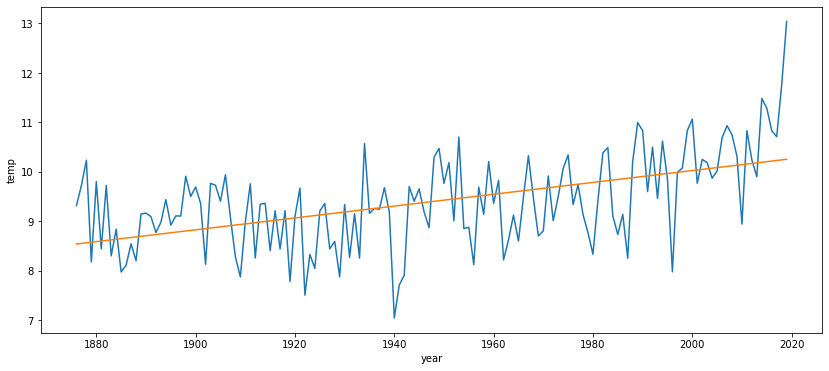

In [26]:
sns.lineplot(x='year', y='temp', data=train.resample('Y').mean())
sns.lineplot(x='year', y='general_trend', data=train.resample('Y').mean())

## Seasonality

In [27]:
season_dummies = pd.get_dummies(train['month'], prefix='month', drop_first=True).set_index(train.index)

In [28]:
X = train[['timestep']].join(season_dummies)
y = train['temp']

m_onehot = LinearRegression()
m_onehot.fit(X,y)

LinearRegression()

In [29]:
train['seasonal_trend'] = m_onehot.predict(X)

In [30]:
m_onehot.score(X, y)

0.7516875839056534

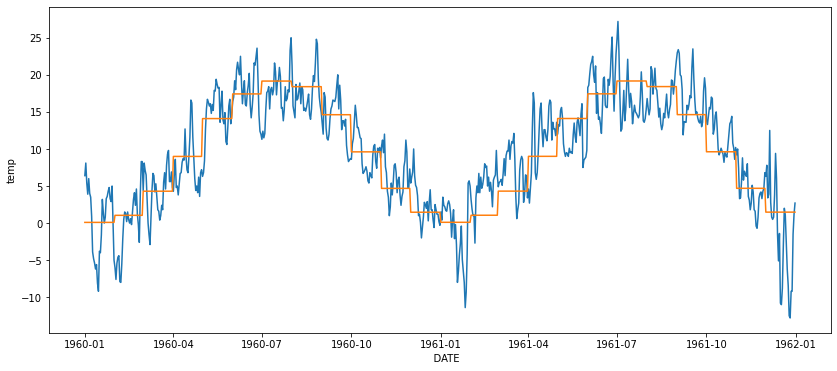

In [31]:
sns.lineplot(x=train['1960':'1961'].index, y='temp', data=train['1960':'1961'])
sns.lineplot(x=train['1960':'1961'].index, y='seasonal_trend', data=train['1960':'1961'])

## Trend with seasonality - Polynomial Feature

In [154]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = pd.DataFrame(poly.fit_transform(train[['month', 'day']]), index=train.index)

In [155]:
poly_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
DATE,,,,,,,,,,,,,,
1876-01-03,1.0,3.0,1.0,3.0,9.0,1.0,3.0,9.0,27.0,1.0,3.0,9.0,27.0,81.0
1876-01-04,1.0,4.0,1.0,4.0,16.0,1.0,4.0,16.0,64.0,1.0,4.0,16.0,64.0,256.0
1876-01-05,1.0,5.0,1.0,5.0,25.0,1.0,5.0,25.0,125.0,1.0,5.0,25.0,125.0,625.0
1876-01-06,1.0,6.0,1.0,6.0,36.0,1.0,6.0,36.0,216.0,1.0,6.0,36.0,216.0,1296.0
1876-01-07,1.0,7.0,1.0,7.0,49.0,1.0,7.0,49.0,343.0,1.0,7.0,49.0,343.0,2401.0


In [156]:
poly_features['timestep'] = train['timestep']
poly_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,timestep
DATE,,,,,,,,,,,,,,,
1876-01-03,1.0,3.0,1.0,3.0,9.0,1.0,3.0,9.0,27.0,1.0,3.0,9.0,27.0,81.0,2
1876-01-04,1.0,4.0,1.0,4.0,16.0,1.0,4.0,16.0,64.0,1.0,4.0,16.0,64.0,256.0,3
1876-01-05,1.0,5.0,1.0,5.0,25.0,1.0,5.0,25.0,125.0,1.0,5.0,25.0,125.0,625.0,4
1876-01-06,1.0,6.0,1.0,6.0,36.0,1.0,6.0,36.0,216.0,1.0,6.0,36.0,216.0,1296.0,5
1876-01-07,1.0,7.0,1.0,7.0,49.0,1.0,7.0,49.0,343.0,1.0,7.0,49.0,343.0,2401.0,6


In [157]:
X = poly_features
y = train['temp']

m_poly = LinearRegression()
m_poly.fit(X,y)

LinearRegression()

In [158]:
train['seasonal_trend_poly'] = m_poly.predict(X)

In [159]:
m_poly.score(X, y)

0.7676136050353624

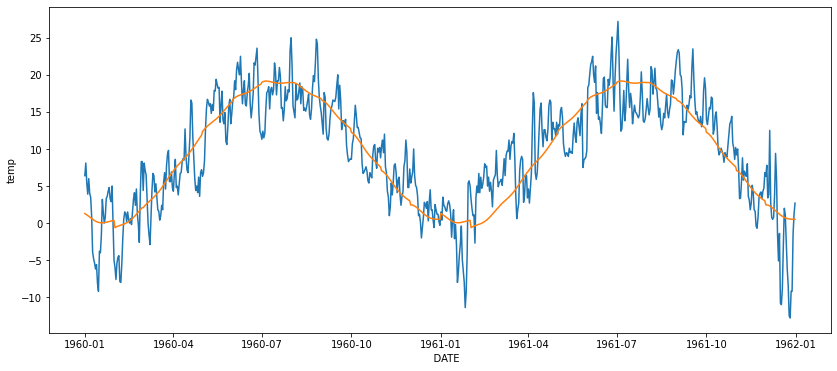

In [38]:
sns.lineplot(x=train['1960':'1961'].index, y='temp', data=train['1960':'1961'])
sns.lineplot(x=train['1960':'1961'].index, y='seasonal_trend_poly', data=train['1960':'1961'])

## Remainder

In [180]:
train['remainder'] = train['temp'] - train['seasonal_trend']

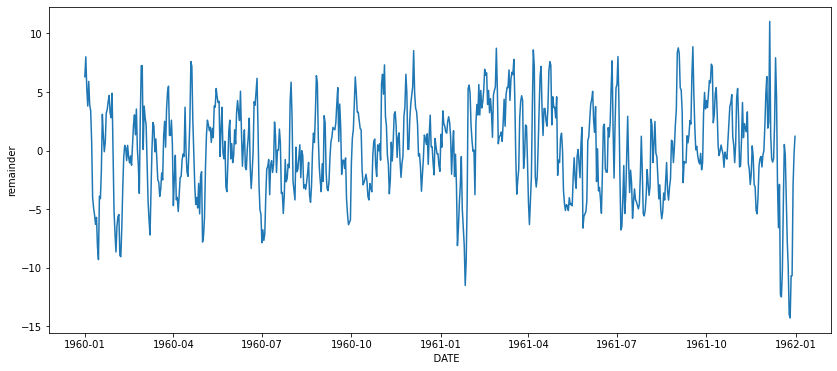

In [181]:
sns.lineplot(x=train['1960':'1961'].index, y='remainder', data=train['1960':'1961'])

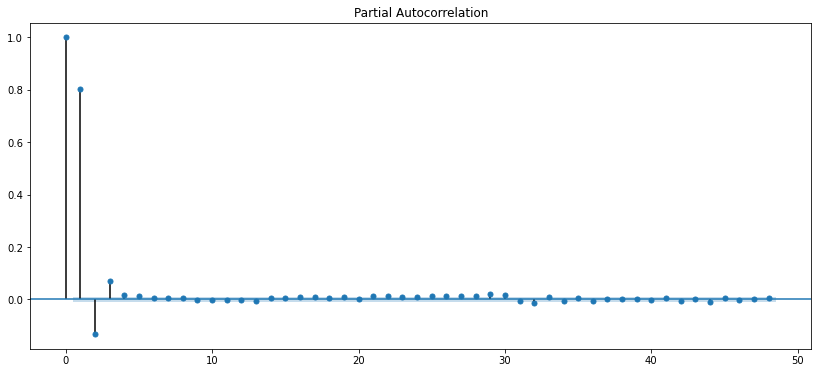

In [182]:
plot_pacf(train['remainder']);

### Check for stationarity 

In [116]:
adfuller(train['remainder'])

(-37.825847642799324,
 0.0,
 21,
 52512,
 {'1%': -3.4304745357192465,
  '5%': -2.8615950422883096,
  '10%': -2.56679929717955},
 233196.32284741395)

### Evaluate Importance of Lags

In [117]:
ar_model = AutoReg(endog=train['remainder'], lags=3).fit()

/Users/marf/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [118]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52534
Model:                     AutoReg(3)   Log Likelihood             -116758.650
Method:               Conditional MLE   S.D. of innovations              2.234
Date:                Wed, 16 Dec 2020   AIC                              1.608
Time:                        20:56:30   BIC                              1.608
Sample:                    01-05-1876   HQIC                             1.608
                         - 11-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     2.733e-05      0.010      0.003      0.998      -0.019       0.019
remainder.L1     0.9229      0.004    212.194      0.000       0.914       0.931
remainder.L2    -0.2067      0.006    -35.284      0.000      -0.218      -0.195
remainder.L3     0.0784      0.004     18.037      0.000       0.070       0.087
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2708           -0.0000j            1.2708           -0.0000
AR.2            0.6820           -3.0929j            3.1672           -0.2155
AR.3            0.6820           +3.0929j            3.1672            0.2155
-----------------------------------------------------------------------------
"""

In [192]:
selected_order = ar_select_order(train['remainder'], maxlag=5) 
selected_order.ar_lags

/Users/marf/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/marf/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


array([1, 2, 3, 4, 5])

## Include Lag1 of Remainder (possibly Lag2 and Lag3)

In [183]:
train['lag1'] = train['remainder'].shift(1)
#train['lag2'] = train['remainder'].shift(2)
train.dropna(inplace=True)

In [184]:
train.columns

Index(['temp', 'year', 'month', 'day', 'timestep', 'general_trend',
       'seasonal_trend', 'seasonal_trend_poly', 'remainder', 'lag1'],
      dtype='object')

In [185]:
X = train[['timestep','lag1']].join(season_dummies)
y = train['temp']

m_onehot_lag1 = LinearRegression()
m_onehot_lag1.fit(X,y)

LinearRegression()

In [186]:
seasonal_trend_lag1_3 = pd.Series(m_onehot_lag1.predict(X), index=y.index)

In [187]:
train.tail(20)

,temp,year,month,day,timestep,general_trend,seasonal_trend,seasonal_trend_poly,remainder,lag1
DATE,,,,,,,,,,
2019-10-13,19.5,2019,10,13,52515,10.259178,10.284180,10.972351,9.215820,6.315851
2019-10-14,18.6,2019,10,14,52516,10.259211,10.284211,10.777034,8.315789,9.215820
2019-10-15,16.1,2019,10,15,52517,10.259243,10.284242,10.585482,5.815758,8.315789
2019-10-16,12.1,2019,10,16,52518,10.259276,10.284274,10.398782,1.815726,5.815758
2019-10-17,14.9,2019,10,17,52519,10.259309,10.284305,10.217800,4.615695,1.815726
2019-10-18,14.8,2019,10,18,52520,10.259342,10.284336,10.043179,4.515664,4.615695
2019-10-19,12.4,2019,10,19,52521,10.259375,10.284367,9.875336,2.115633,4.515664
2019-10-20,15.0,2019,10,20,52522,10.259407,10.284399,9.714466,4.715601,2.115633
2019-10-21,14.6,2019,10,21,52523,10.259440,10.284430,9.560542,4.315570,4.715601


In [188]:
seasonal_trend_lag1_3.tail()

    DATE
2019-10-28    11.567096
2019-10-29     8.753209
2019-10-30     6.260909
2019-10-31     4.492182
2019-11-01    -1.199829
dtype: float64

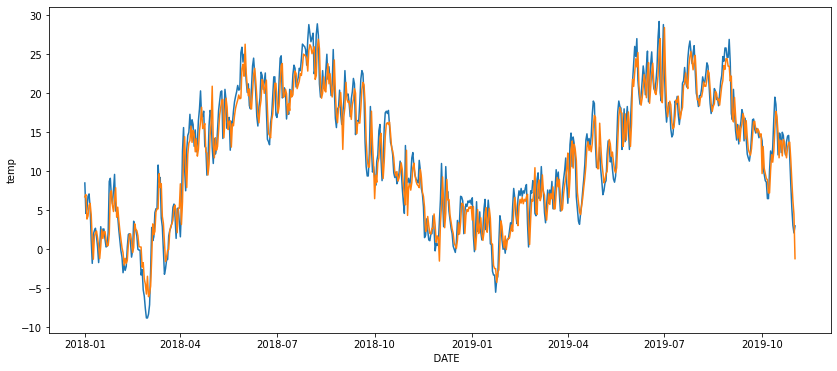

In [190]:
sns.lineplot(x=train['2018':'2019'].index, y='temp', data=train['2018':'2019'])
sns.lineplot(x=train['2018':'2019'].index, y=seasonal_trend_lag1_3['2018':'2019'], data=train['2018':'2019'])

In [191]:
m_onehot_lag1.score(X,y)

0.9121727761769929

### Clean Code, Set Baseline, Wrap Data Cleaning & Feature Engineering in functions, seperate EDA and Modelling more clearly

# Cross-Validation

In [192]:
# Create a TimeSeriesSplit object
time_series_split = TimeSeriesSplit(n_splits=5)
splits = time_series_split.split(X, y) 
cv = cross_val_score(estimator=m_onehot_lag1, X=X, y=y, cv=splits)
cv.mean()

0.9099621689762106

# Test evaluation

In [194]:
test = time_features(test)

In [195]:
X_test = pd.DataFrame(index=test.index)

In [196]:
y_test = test['temp']

In [197]:
X_test['timestep'] = list(range(train['timestep'][-1]+1, len(X_test) + train['timestep'][-1]+1))

In [198]:
seasonal_dummies = pd.get_dummies(test.index.month, prefix='month', drop_first=True).set_index(test.index)
X_test = X_test.join(seasonal_dummies)

In [199]:
 test['seasonal_trend'] = m_onehot.predict(X_test)

In [200]:
test['remainder'] = test['temp'] - test['seasonal_trend']

In [201]:
X_test['lag1'] = test['remainder'].shift(1)
#X_test['lag2'] = test['remainder'].shift(2)

In [202]:
test.head()

,temp,year,month,day,seasonal_trend,remainder
DATE,,,,,,
2019-11-02,11.3,2019,11,2,5.355395,5.944605
2019-11-03,10.9,2019,11,3,5.355426,5.544574
2019-11-04,10.4,2019,11,4,5.355457,5.044543
2019-11-05,9.5,2019,11,5,5.355489,4.144511
2019-11-06,8.2,2019,11,6,5.355520,2.844480


In [204]:
 X_test['lag1'][0] = train['remainder'][-1]
 #X_test['lag2'][0] = train['remainder'][-2]
 #X_test['lag2'][1] = train['remainder'][-1]

In [205]:
test['prediction_full'] = m_onehot_lag1.predict(X_test)

In [206]:
m_onehot_lag1.score(X_test, y_test)

0.4972079595955633

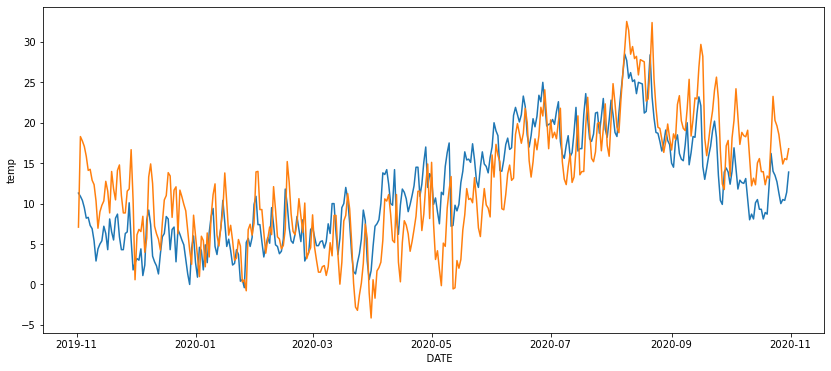

In [207]:
sns.lineplot(x=test.index, y='temp', data=test)
sns.lineplot(x=test.index, y='prediction_full', data=test)